<img src="http://escolar.itam.mx/centro_tesis/img/logo-ITAM.png" style="width:250px">

# <center>Brain theory and neuroinformatics</center>

## <center>maxSelector</center>

#### <center>Gustavo Augusto Mondragón Sánchez : 136894</center>

### Introducción:

#### Rana indecisa
Las ranas, al igual que nosotros los humanos, tienen un sistema nervioso con un cerebro que procesa los estímulos del mundo exterior y los traduce en acciones. En 1976 Richard L. Didday publicó *"A Model of Visuomotor Mechanisms in the Frog Optic Tectum"* en el que describía un modelo de información-procesamiento en el sistema visual de la rana. A lo largo de la publicación Didday desarrolla un modelo basado en cómo al combinar estímulos individuales se puede producir una respuesta realistica para una situación con multiples presas. Multiples presas requieren toma de decisiones, para que el lengüetazo de la rana no termine en la mancha de gransa en la pared junto a las diez moscas.
Para que la decisión tenga éxito el sistema de la rana debe tener la capacidad de dar una gran relevancia a ciertos estímulos y a ignorar otros.

<img src="visualSystem.png" style="width:1000px">

La forma de determinar qué estimulos son los más fuertes y cuales deben ser desechados es mediante el módulo *Maximum Selector*. 
Basado en el modelo Didday, el selector máximo, recibe dos o más entradas y después de un procesamiento permite que el valor máximo de éstas permanezca activo. Este tipo de red neuronal es generalmente conocida como *"Winner take all"* o el ganador toma todo.

#### Histéresis 
Histéresis es la dependencia del estado del sistema a sus estados previos (su historia).
Histéresis puede ser un retráso dinámico entre la entrada y la salida que desaparece su la entrada varía más lentamente. 
Un ejemplo importante de este fenómeno en la neourociencia se encuentra en las neuronas. Algunas neuronas no regresan a su potencial de reposo de forma instantanea al quitar el estímulo que la activó sino que posee una fase refractaria en la que la *repolarización* y la *hyperpolarización* son ejemplos de histéresis.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Action_potential.svg/300px-Action_potential.svg.png" style="width:300px">


### Objetivos: 
* Agregar integración numérica usando Euler
* Agregar la nueva capa motora.
* Incluir gráficas de la dirección del lengüetazo

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Definición de funciones

In [2]:
#Función escalón
def step(pot, thr, val_less, val_gr_eq):
    return np.where(pot<thr,val_less,val_gr_eq)

In [3]:
#Función rampa
def ramp(pot, thr):
    return np.where(pot<thr, 0, pot)

In [203]:
#Función para hallar la solución a la función diferencial
def diff(ini, tau, f):
    return ini + (0.1/tau)*f

In [161]:
#Función para graficar los resultados de Maximum Selector
def graficaMaxSelector(ups_,ufs_,vps_,vfs_):
    n = vfs_.shape[0]
    size = ups_.shape[1]
    plt.figure(figsize=(30, 5))
    for i in range (0,size):
        plt.subplot(1, size, (i+1))
        plt.plot(range(0,n),np.repeat(0, n))
        plt.plot(range(0,n),ufs_[:,i])
        plt.title("Neuron Output %d"%(i+1))
        plt.xlabel("Time")
        plt.ylim([-1.1,1.1])
    plt.show()

    plt.figure(figsize=(30, 5))
    for i in range (0,size):
        plt.subplot(1, size, (i+1))
        plt.plot(range(0,n),np.repeat(k_u, n))
        plt.plot(range(0,n),ups_[:,i])
        plt.title("Neuron Potential %d"%(i+1))
        plt.xlabel("Time")
        plt.ylim([np.min(ups)*1.1,np.max(ups)*1.1])
    plt.show()

    plt.figure(figsize=(30, 5))
    plt.plot(range(0,n),vps_)
    plt.plot(range(0,n),vfs_)
    plt.title("Inhibition (Selector)")
    plt.legend(["Potential","Output"])
    plt.ylabel("Magnitude")
    plt.xlabel("Time")
    plt.show()
    
    #Dirección del lengüetazo
    #x = np.arange(0, 10, 1.0)
    #y = ufs[-1,:]
    #print "lengüetazo",np.dot(x,y)*.1

In [347]:
#Función que modela el coomportamiento del Maximum Selector
def maxSelector(time, delta, stimulus, tau_u, tau_v, wu, wm, wn, hu, hv, k_u, printB):
    size = len(stimulus)
    n = int(time/delta)
    
    up = np.zeros((size,1))   #Potencial membrana de entradas
    uf = np.zeros((size,1))   #disparo de salida
    vp = 0.0    #Potencial membrana salida
    vf = 0.0   #disparo salida

    ups = np.zeros((n,size,1))
    ufs = np.zeros((n,size,1))
    vps = np.zeros((n,1))
    vfs = np.zeros((n,1))
    i = 0
    for t in np.arange(0.0, time, delta):
        #Neuronas de entrada de estímulos
        ecMembrana = -up + wu*uf - wm*vf - (hu if type(hu)==float else hu.T) + stimulus
        up = diff(up, tau_u, ecMembrana)
        uf = step(up, k_u, 0.0, 1.0)
        #Neurona única de salida
        ecDisp = - vp + wn*np.sum(uf) - hv 
        vp = diff(vp, tau_v, ecDisp)
        vf = ramp(vp, 0.0)
    
        ups[i] = up
        ufs[i] = uf
        vps[i] = vp
        vfs[i] = vf
        i = i+1
        
        if (printB>0):
            print("\nStep %0.1f"%(t+.1))
            print "Up:",up.T
            print "Vp",vp
            print "Uf:",uf.T
            print "Vf",vf
            
    return ups, ufs, vps, vfs

### Parámetros del modelo

In [204]:
time = 10
delta = 0.1

stimulus = np.array([[0.0, 1.0, 0.0, 0.65, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T
print "Estímulos: ",stimulus.T

tau_u = 1.0   #Constante de tiempo
tau_v = 1.0   #Constante de tiempo

wu = 1.0   #Peso conexión estímulo-estímulo (cíclica)
wm = 1.0   #Peso conexión inhibición-estímulo  (feedback)
wn = 1.0   #Peso conexión estímulo-inhibición

#Los potenciales deben ser siempre mayores a cero.

hu = 0.2   #nivel de descanso en el estìmulo 
hv = 0.5   #nivel de descanso en el inhibidor

k_u = 0.2  #Umbral de activación

Estímulos:  [[ 0.    1.    0.    0.65  0.    0.    0.    0.    0.    0.  ]]


### Generar simulación

In [205]:
ups, ufs, vps, vfs = maxSelector(time, delta, stimulus, tau_u, tau_v, wu, wm, wn, hu, hv, k_u,0)

### Gráficas

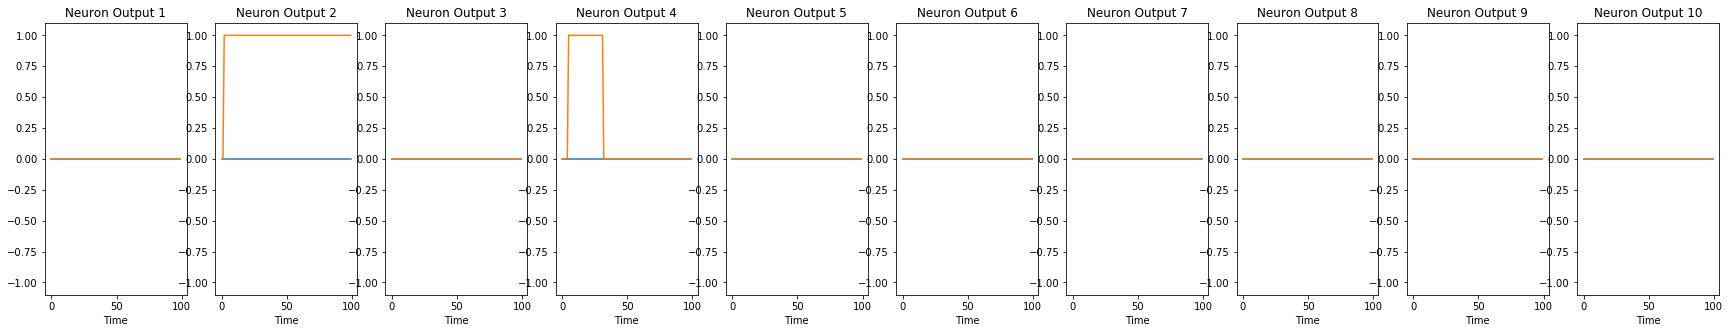

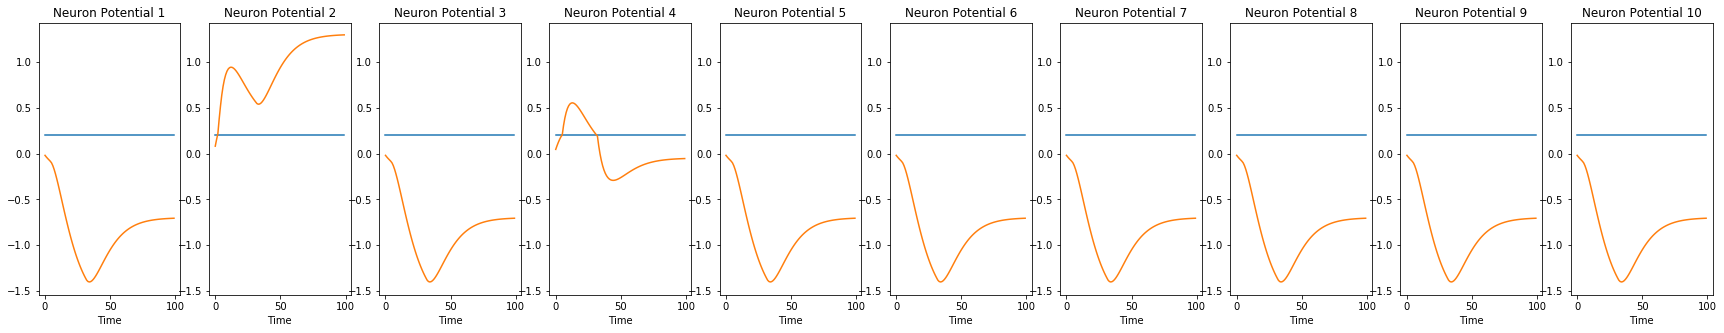

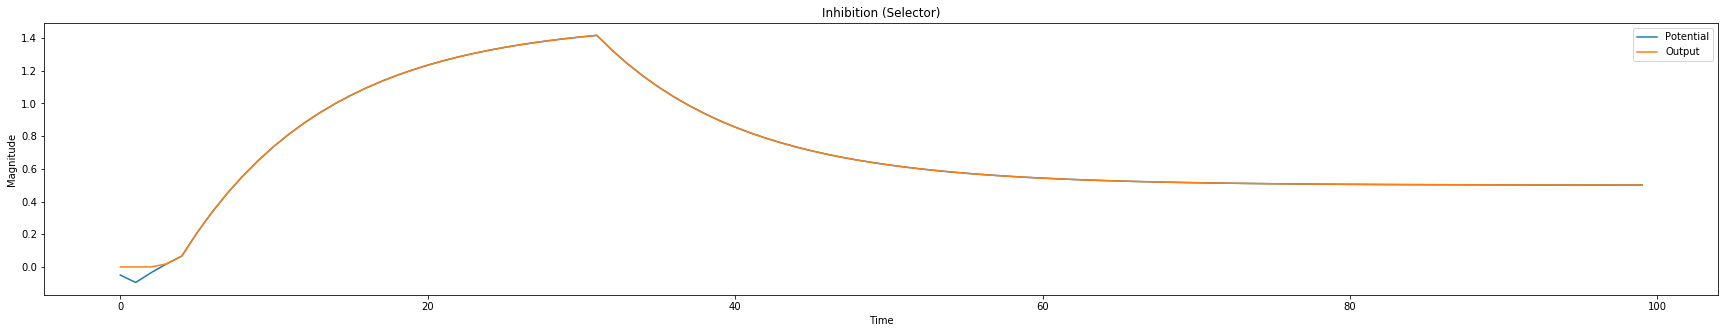

In [206]:
graficaMaxSelector(ups,ufs,vps,vfs)

### ¿Qué pasa cuando hay dos parámetros iguales? ¿Dónde da el lengüetazo? 

Si la magnitud es lo suficientemente alta como para alcanzar el umbral se activaría cada neurona. Daría el lengüetazo en la posición promedio de estas.

Estímulos:  [[ 0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]]


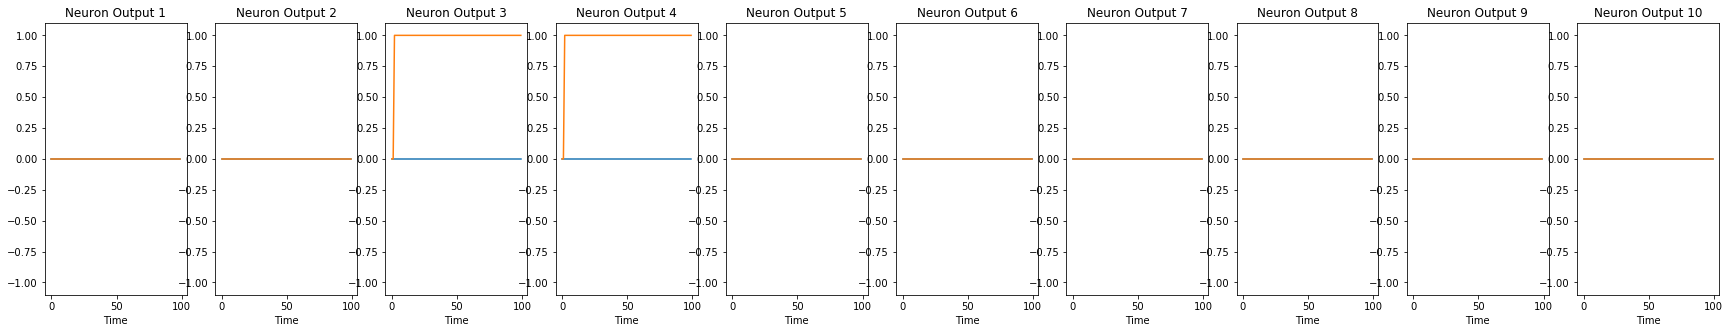

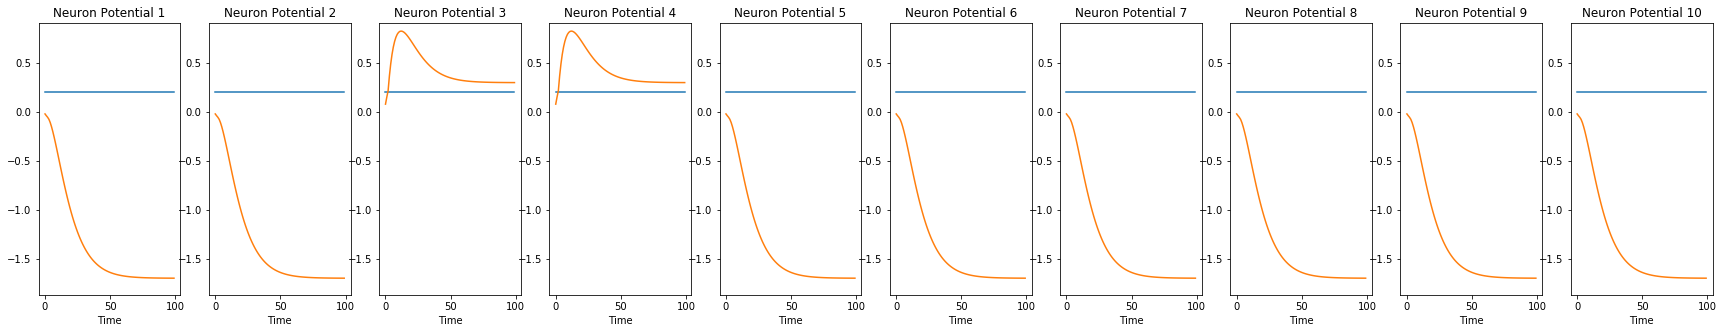

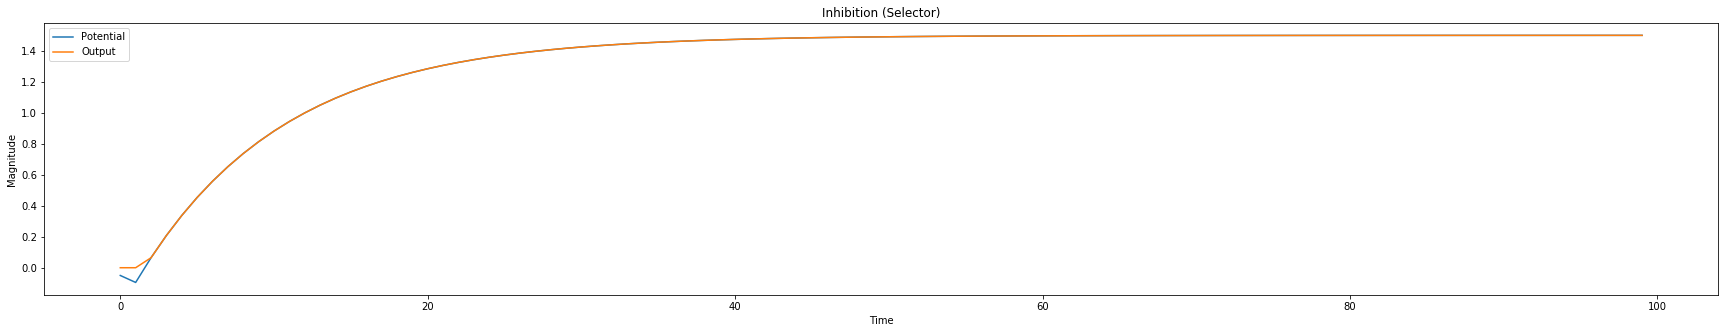

In [349]:
time = 10
delta = 0.1

stimulus = np.array([[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T #Dos parámetros iguales
print "Estímulos: ",stimulus.T

tau_u = 1.0   #Constante de tiempo
tau_v = 1.0   #Constante de tiempo

wu = 1.0   #Peso conexión estímulo-estímulo (cíclica)
wm = 1.0   #Peso conexión inhibición-estímulo  (feedback)
wn = 1.0   #Peso conexión estímulo-inhibición

#Los potenciales deben ser siempre mayores a cero.

hu = 0.2   #nivel de descanso en el estìmulo 
hv = 0.5   #nivel de descanso en el inhibidor

k_u = 0.2  #Umbral de activación

ups, ufs, vps, vfs = maxSelector(time, delta, stimulus, tau_u, tau_v, wu, wm, wn, hu, hv, k_u, 0)

graficaMaxSelector(ups,ufs,vps,vfs)

### ¿Qué parámetros debo usar para sólo de respuesta cuando hay dos máximos iguales?
    

Estímulos:  [[ 0.   0.   0.8  0.8  0.   0.   0.   0.   0.   0. ]]
Máximo debe ser menor a [[ 0.7   0.71  0.72  0.73  0.74  0.75  0.76  0.77  0.78  0.79]]


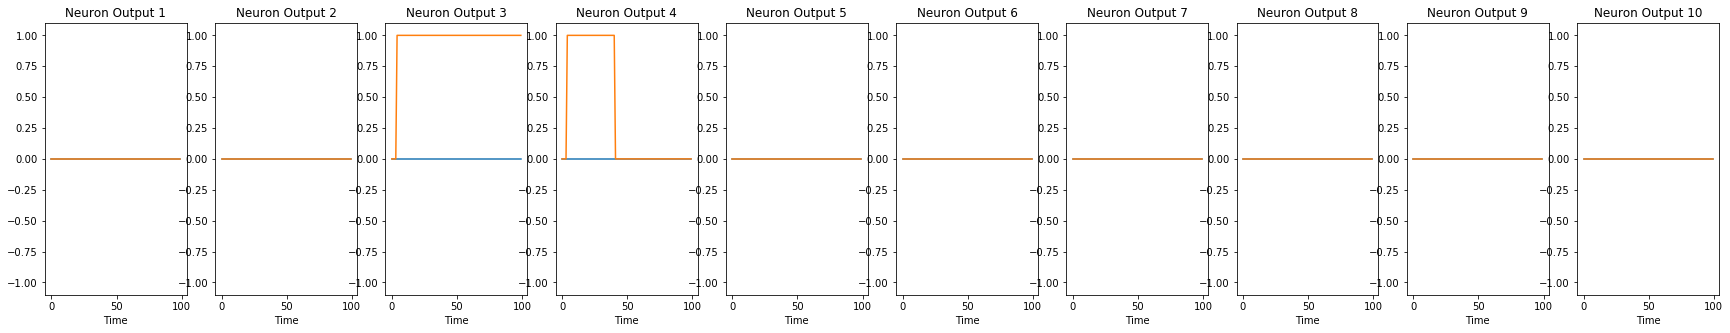

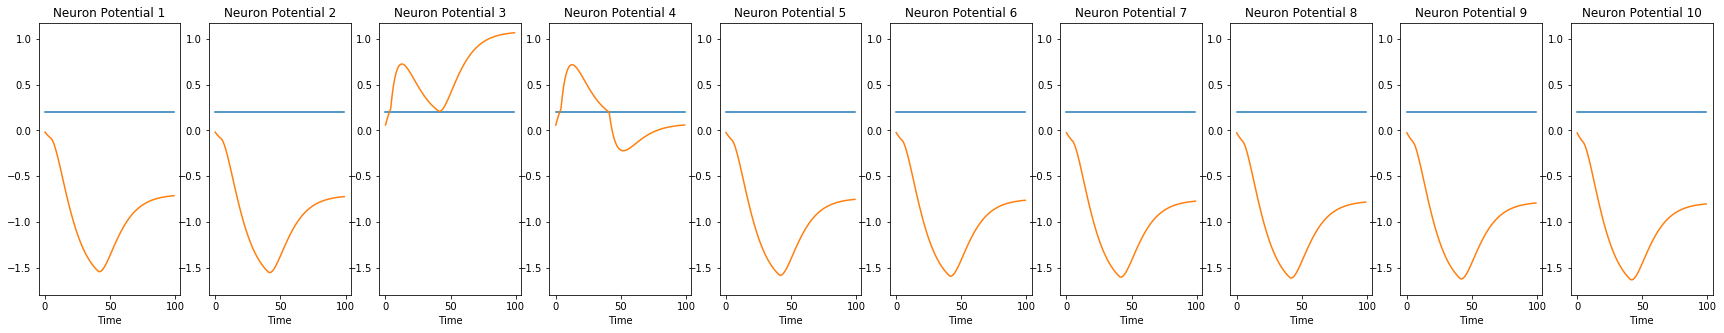

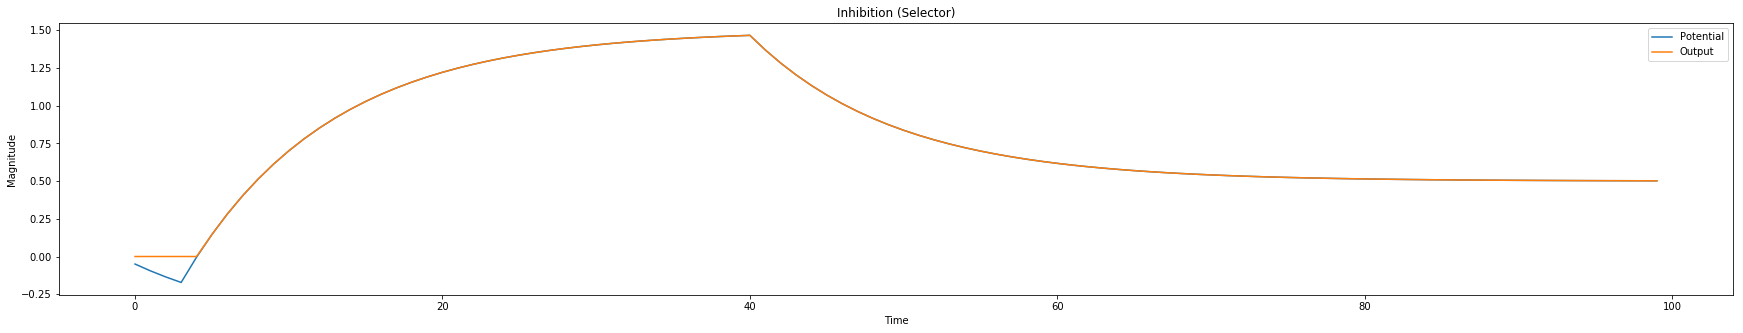

In [348]:
time = 10
delta = 0.1

stimulus = np.array([[0.0, 0.0, 0.8, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T #Dos parámetros iguales
print "Estímulos: ",stimulus.T

tau_u = 1.0   #Constante de tiempo
tau_v = 1.0   #Constante de tiempo

wu = 1.0   #Peso conexión estímulo-estímulo (cíclica)
wm = 1.0   #Peso conexión inhibición-estímulo  (feedback)
wn = 1.0   #Peso conexión estímulo-inhibición

#Los potenciales deben ser siempre mayores a cero.

hu = np.array([[0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29]])   #nivel de descanso en el estìmulo 
hv = 0.5   #nivel de descanso en el inhibidor

k_u = 0.2  #Umbral de activación

print "Máximo debe ser menor a",hu-wu+(2-hv)*(wm)


ups, ufs, vps, vfs = maxSelector(time, delta, stimulus, tau_u, tau_v, wu, wm, wn, hu, hv, k_u, 0)

graficaMaxSelector(ups,ufs,vps,vfs)

### ¿Cómo reproducir el fenómeno de histéresis? 

Como se aprecia arriba el comportamiento de la red es proporcional a los cambios en la función $\frac{dS_i}{dt}$ (donde $S_i$ es el estímulo i) donde a la función que describe los comportamientos de la ecuación diferencial no son derivables, es decir, son funciones por partes, con funciones diferentes como una simoide podríamos obtener un comportamiento que simule la histéresis.

### Bibliografía:
#### [*"A model of visuomotor mechanisms in the frog optic tectum."* Richard L.Didday, 1976](https://ac.els-cdn.com/0025556476900249/1-s2.0-0025556476900249-main.pdf?_tid=24e0a502-a56a-11e7-ba1a-00000aab0f27&acdnat=1506726276_2bce570244ee867890777ab63497c4ed)
#### [*"NSL Lenguaje de Simulación de Redes Neuronales. Un Sistema para el modelado biológico y artificial".*Alfredo Weitzenfeld, 2001](http://www.medigraphic.com/pdfs/inge/ib-2001/ib012c.pdf)

#### [*"Embedded Mobile Systems: From Brain Theory To Neural-based Robots".* Alfredo Weitzenfeld](http://ftp.itam.mx/pub/alfredo/PAPERS/T2-029.pdf)

#### [Wikipedia, Action Potential](https://en.wikipedia.org/wiki/Action_potential)
#### [Wikipedia, Hysteresis](https://en.wikipedia.org/wiki/Hysteresis#Neuroscience)
